<img src="./images/QIBM-logo.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Single-qubit state tomography*_ <br />with the Python Interface for the Web API<br /> of the IBM Quantum Experience
© IBM Research

The latest version of this notebook is available on https://github.ibm.com/QuantumSDK/qx-sdk/scripts/.

For more information about how to use the Quantum Experience consult the [IBM Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Andrew Cross

## Introduction

State tomography is a method for estimating the density matrix of a quantum state. A single-qubit state $\rho=(I+a_xX+a_yY+a_zZ)/2$ is fully determined by the expectation value of each Pauli operator. For example, $\langle X\rangle = \mathrm{Tr}(X\rho) = a_x$. The resulting vector $(a_x,a_y,a_z)$ is called the Bloch vector. Since $\rho$ is positive and $\mathrm{Tr}(\rho)=1$, $\mathrm{Tr}(\rho^2)\leq 1$. This implies that the Bloch vector lies on or within the unit sphere.

This notebook shows how to annotate a circuit with "bloch" gates to carry out single-qubit state tomography at select circuit locations. If the input circuit contains $m$ "bloch" gates, the make_bloch_circuits helper function makes a dictionary of $3m$ QASM strings to estimate the expectation values of $X$, $Y$, and $Z$ at each of the $m$ circuit locations. If you like, "bloch" gates can be viewed as a debugging tool for your quantum circuits.

For each occurrence of "bloch", the helper function (a) replaces the "bloch" gate with single-qubit gates and measurements, (b) deletes the future light cone of that "bloch" gate, and (c) removes all other "bloch" gates. All of the classical registers are renamed with "aaa" prepended. State tomography measurements are written to c[0]. If you run on the real hardware, there is only one creg, so you will need to delete "creg c[5];" from your input QASM as well as any measurements.

The examples below creates a Bell state $|\psi\rangle:=\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$. We annotate the circuit to show that qubit q[0] begins in the state $|0\rangle$ on the north pole of the Bloch sphere and rotates to $|+\rangle$ on the equator. Qubits q[0] and q[1] interact via a CNOT and become the maximally entangled state $|\psi\rangle$. When you observe either q[0] or q[1] in isolation, they each appear to be in the maximally mixed state $\rho=I/2$ at the center of the Bloch sphere.

In [1]:
import sys
sys.path.append("..")
from Qhelpers.basicPlotter import plotBlochVector
from Qhelpers import bloch
from IBMQuantumExperience import IBMQuantumExperience
import Qconfig

config = {"url": 'https://quantumexperience.ng.bluemix.net/api'} # base url for the IBMQE API
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APIemail,Qconfig.APIpassword, config)

Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


bloch #0 -- qubit q[0], parameters ['1.0']
bloch #1 -- qubit q[0], parameters ['2.0']
bloch #2 -- qubit q[0], parameters ['3.0']
bloch #3 -- qubit q[1], parameters ['4.0']
device=sim, shots=1024, expname=Simple_Bloch_Example_0_x
device=sim, shots=1024, expname=Simple_Bloch_Example_0_y
device=sim, shots=1024, expname=Simple_Bloch_Example_0_z
device=sim, shots=1024, expname=Simple_Bloch_Example_1_x
device=sim, shots=1024, expname=Simple_Bloch_Example_1_y
device=sim, shots=1024, expname=Simple_Bloch_Example_1_z
device=sim, shots=1024, expname=Simple_Bloch_Example_2_x
device=sim, shots=1024, expname=Simple_Bloch_Example_2_y
device=sim, shots=1024, expname=Simple_Bloch_Example_2_z
device=sim, shots=1024, expname=Simple_Bloch_Example_3_x
device=sim, shots=1024, expname=Simple_Bloch_Example_3_y
device=sim, shots=1024, expname=Simple_Bloch_Example_3_z
bloch vectors =
[(-0.01171875, -0.01171875, 1.0), (1.0, -0.01171875, -0.01171875), (-0.01171875, -0.01171875, -0.01171875), (-0.01171875, -0.011

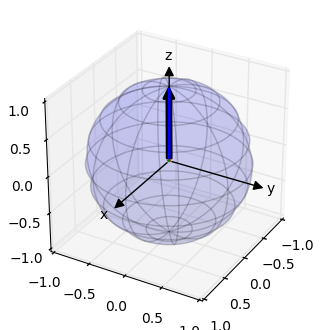

bloch #1, params=2.0


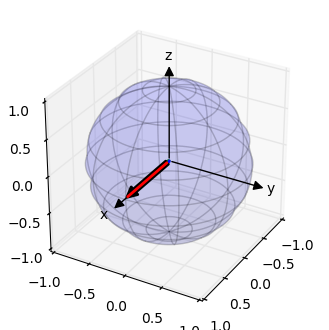

bloch #2, params=3.0


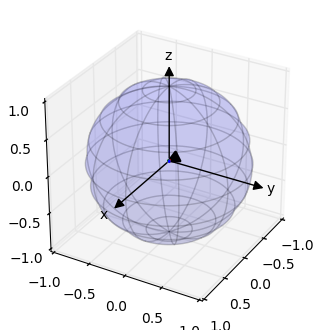

bloch #3, params=4.0


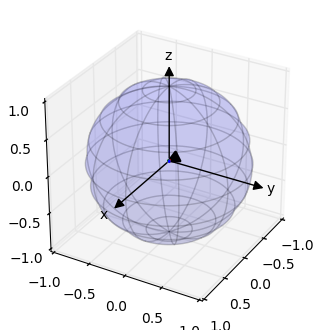

In [2]:
device = "sim"
shots = 1024
basename="Simple_Bloch_Example"
# Simulator inputs can contain cregs, measurements, and ifs
mysrcsim="""
IBMQASM 2.0;
include "qelib1.inc";
opaque bloch(p) q;
qreg q[5];
creg c[5];
bloch(1) q[0];
h q[0];
bloch(2) q[0];
cx q[0],q[1];
bloch(3) q[0];
bloch(4) q[1];
h q[2];
measure q[2] -> c[0];
if(c==1) x q[2];
"""

# Real device inputs cannot contain any cregs - your job will fail
mysrcreal="""
IBMQASM 2.0;
include "qelib1.inc";
opaque bloch(p) q;
qreg q[5];
bloch(1) q[0];
h q[0];
bloch(2) q[0];
cx q[0],q[1];
bloch(3) q[0];
bloch(4) q[1];
"""

# TODO: Add 0 and 1 experiments to compensate for readout error

# Generate and execute each experiment on the Quantum Experience
exps = bloch.make_bloch_circuits(mysrcsim)
blochvecs = []
for i in range(len(exps)):
    results = []
    for m in ["x","y","z"]:
        expname=basename+"_%d_%s"%(i,m)
        print("device=%s, shots=%s, expname=%s"%(device,shots,expname))
        #print("%s\n"%exps[i][m])
        out = api.runExperiment(exps[i][m],device,shots,expname)
        #print("%s"%out)
        results.append(out["result"]["measure"])
    xdat = dict(zip(results[0]["labels"],results[0]["values"]))
    ydat = dict(zip(results[1]["labels"],results[1]["values"]))
    zdat = dict(zip(results[2]["labels"],results[2]["values"]))
    #print("xdat=%s, ez=%f"%(xdat,bloch.ez(xdat,0)))
    #print("ydat=%s, ez=%f"%(ydat,bloch.ez(ydat,0)))
    #print("zdat=%s, ez=%f"%(zdat,bloch.ez(zdat,0)))
    blochvecs.append((bloch.ez(xdat,0),bloch.ez(ydat,0),bloch.ez(zdat,0)))

# Report and plot the results
print("bloch vectors =\n%s"%blochvecs)
for i in range(len(blochvecs)):
    print("bloch #%s, params=%s"%(i,",".join(exps[i]["key"])))
    plotBlochVector(blochvecs[i])
